In [1]:
!pip install feature_engine

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 276.4/276.4 kB 492.0 kB/s eta 0:00:00a 0:00:01


In [2]:
pip install statsmodels

Note: you may need to restart the kernel to use updated packages.


In [3]:
import subprocess
subprocess.run('conda install -c conda-forge r-base', shell=True)


CondaError: KeyboardInterrupt



KeyboardInterrupt: 

In [ ]:
pip install rpy2

In [ ]:
from rpy2.robjects import r

In [ ]:
pip install caret

**Python 包**

In [4]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import warnings
warnings.filterwarnings('ignore')
# Plots
import seaborn as sns
import matplotlib.pyplot as plt

from feature_engine.imputation import MeanMedianImputer

import statsmodels.api as sm
import pylab

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


**R 包**

In [ ]:
from rpy2.robjects.packages import importr
# imports the base module for R.
base = importr("base")
 
# imports the utils package for R.
utils = importr("utils")

#ti = importr('tidyverse')
#importr('caret')
#importr('leaps')

**数据基本情况检查**

In [5]:
train = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/train.csv')
test = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/test.csv')
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [ ]:
pd.DataFrame(data = [train.isna().sum()/train.shape[0]*100, test.isna().sum()/test.shape[0]*100], 
             index=["Train Null (%)", "Test Null (%)"]).T.style.background_gradient(cmap='summer_r')

In [6]:
train_data = train.drop(['Alley','PoolQC','Fence','MiscFeature','FireplaceQu'],axis = 1)
test_data = test.drop(['Alley','PoolQC','Fence','MiscFeature','FireplaceQu'],axis = 1)

In [ ]:
sns.set_style("white")
sns.set_color_codes(palette='deep')
f, ax = plt.subplots(figsize=(8, 7))
#Check the new distribution 
sns.distplot(train['SalePrice'], color="b")
ax.xaxis.grid(False)
ax.set(ylabel="Frequency")
ax.set(xlabel="SalePrice")
ax.set(title="SalePrice Distribution")
sns.despine(trim=True, left=True)
plt.show()

In [ ]:
# 斜度 和 曲度
print("Skewness: %f" % train['SalePrice'].skew())
print("Kurtosis: %f" % train['SalePrice'].kurt())

In [ ]:
sns.set_style("white")
sns.set_color_codes(palette='deep')
f, ax = plt.subplots(figsize=(8, 7))
#Check the new distribution 
sns.distplot(np.log(train['SalePrice']), color="b")
ax.xaxis.grid(False)
ax.set(ylabel="Frequency")
ax.set(xlabel="log SalePrice")
ax.set(title="log SalePrice Distribution")
sns.despine(trim=True, left=True)
plt.show()

In [ ]:
# 斜度 和 曲度
print("Skewness: %f" % np.log(train['SalePrice']).skew())
print("Kurtosis: %f" % np.log(train['SalePrice']).kurt())

**所以我们考虑对lnY回归**

In [7]:
# Finding numeric features
# 这样分出来的不全是数值型的
numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
num = []
cat = []
for i in train_data.columns:
    if (train_data[i].dtype in numeric_dtypes)&(i != 'SalePrice'):
            num.append(i)  
    elif i != 'SalePrice': #elif train_data[i].dtype=='object'
            cat.append(i) 

In [8]:
#对num、cat进行人工校对,可能还有那天晚上后来没注意了
change = ['MSSubClass','OverallQual']
for c in change:
    num.remove(c)
    cat.insert(-1,c)

**各变量分布情况**

In [ ]:
def num_dist(data, var):
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))

    sns.histplot(data=data, x=var, kde=True, ax=ax[0])
    sns.boxplot(data=data, x=var, ax=ax[1])
    ax[0].set_title(f"{var} Distribution Histogram")
    ax[1].set_title(f"{var} Distribution Boxplot")

    plt.show()
for var in num:
    num_dist(train, var)

In [ ]:
def cat_dist(data, var):
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))

    train_data[var].value_counts().plot(kind="pie", explode=[0.05 for x in data[var].dropna().unique()], autopct='%1.1f%%', ax=ax[0], shadow=True)
    ax[0].set_title(f"{var} Pie Chart")
    ax[0].set_ylabel('')

    count = sns.countplot(x=var, data=train_data, ax=ax[1])
    for bar in count.patches:
        count.annotate(format(bar.get_height()),
            (bar.get_x() + bar.get_width() / 2,
            bar.get_height()), ha='center', va='center',
            size=11, xytext=(0, 8),
            textcoords='offset points')
    ax[1].set_title(f"{var} Bar Chart")
    plt.show()

for c in cat:
    cat_dist(train,c)


**缺失值补齐**

https://www.kaggle.com/code/dansbecker/handling-missing-values

连续型：

1. 缺失值占比很少很少的用平均值或者中位数？？？0%~10% sklearn.impute.SimpleImputer

2. 缺失值稍微大的用????  10%以上的50%以下的

3. 50%以上的扔了吧

分类:

并不是很多，把缺的行删了

In [9]:
# 连续型，只有一个用中位数补齐
median_imputer = MeanMedianImputer(imputation_method="median")
train_data[num] = median_imputer.fit_transform(train_data[num])
test_data[num] = median_imputer.transform(test_data[num])

In [10]:
# 合并数据进行数据处理
train_data.insert(train_data.shape[1],'lable',np.ones(train_data.shape[0]))
test_data.insert(test_data.shape[1],'lable',np.zeros(test_data.shape[0]))
data = pd.concat([train_data,test_data],axis = 0)

In [11]:
# 分类
missing = (data.isna().sum()!=0)[data.isna().sum()!=0].index.values
cat_missing = []
for m in missing:
    if m in cat:
        cat_missing.append(m)
data.dropna(subset = cat_missing,axis=0,inplace = True)

In [12]:
# 删去变量，需要有个人写一下解释原因，结合图像和数据分析
drop_ = ['Id','Neighborhood','Condition1','Condition2','Exterior1st','Exterior2nd','BsmtQual','BsmtFinType1','BsmtFinSF1',
        'BsmtFinType2','BsmtFinSF2','Heating','GarageYrBlt','GarageFinish','GarageCars','MoSold','YrSold']
data.drop(drop_,axis = 1,inplace = True)

In [13]:
# 更新变量分类
for d in drop_:
    for c in cat:
        if d==c:
            cat.remove(c)
    for n in num:
        if d==n:
            num.remove(n)
data = data.reset_index()

**特征工程** 

1. YearBuilt 分箱

In [14]:
def box_yearbuild(col):
    peroid1 = [0]*len(col)
    peroid2 = [0]*len(col)
    for i in range(0,len(col)):
        if col[i]<=1950:
            peroid1[i] = 1
        elif col[i] > 1980:
            peroid2[i] = 1
    per = pd.DataFrame(peroid1,columns = ['YearBuilt_Before1950'])
    per.insert(1,'YearBuilt_After1980',peroid2)
    return per
data = pd.concat([data,box_yearbuild(data['YearBuilt'])],axis = 1)
data.drop('YearBuilt', axis = 1,inplace = True)

2. YearRemodAdd 分箱

In [15]:
def box_yearremod(col):
    peroid = [0]*len(col)
    for i in range(0,len(col)):
        if col[i]<=1990:
            peroid[i] = 1
    per = pd.DataFrame(peroid,columns = ['YearRemodel_before1990'])
    return per
data = pd.concat([data,box_yearremod(data['YearRemodAdd'])],axis = 1)
data.drop('YearRemodAdd', axis = 1,inplace = True)

3.  比例构造

    BsmtUnfSF/TotalBsmtSF 未完成的地下室占比

    LowQualFinSF/GrLivArea 

In [16]:
def ratio(data,num,den,new_name):
    ratio = data[num]/data[den]
    data.insert(data.shape[1],new_name,ratio)
    data.drop([num, den],axis = 1, inplace = True)
ratio(data,'BsmtUnfSF','TotalBsmtSF','UnfinishedBsm_ratio')
ratio(data,'LowQualFinSF','GrLivArea','LowQuality_ratio')

4. 卫生间面积合并

In [17]:
def Bath_combine(data):
    Bath = 0.5*(0.6*data['HalfBath']+0.4*data['BsmtHalfBath'])+0.6*data['FullBath']+0.4*data['BsmtFullBath']
    data.insert(data.shape[1],'Bath_total',Bath)
    data.drop(['HalfBath', 'BsmtHalfBath', 'FullBath', 'BsmtFullBath'],axis = 1, inplace = True)
Bath_combine(data)

5. 门廊合并

In [18]:
def Porch_combine(data):
    porch = [0]*data.shape[0]
    for a in data.columns:
        if 'Porch' in a:
            porch += data[a]
            data.drop(a, axis = 1, inplace = True)
    data.insert(data.shape[1],'Porch',porch)
Porch_combine(data)

6. GarageQual & Cond 比较留

In [19]:
def compare(data):
    dic = {'Ex':6, 'Gd':5, 'TA':4, 'Fa':3, 'Po':2, 'NA':1}
    Garage = []
    for i in range(data.shape[0]):
        if data['GarageQual'].map(dic)[i] <= data['GarageCond'].map(dic)[i]:
            Garage.append(data['GarageQual'][i])
        else: 
            Garage.append(data['GarageCond'][i])
    data.insert(data.shape[1],'Garagelevel',Garage)
    data.drop(['GarageQual','GarageCond'], axis = 1, inplace = True)
compare(data)

**重新提取数值型和分类变量**

In [20]:
num = []
cat = []
data.drop('index',axis = 1,inplace = True)
for i in data.columns:
    if (data[i].dtype in numeric_dtypes)&(i != 'SalePrice'):
            num.append(i)  
    elif i != 'SalePrice': #elif train_data[i].dtype=='object'
            cat.append(i) 
change = ['YearBuilt_Before1950','YearBuilt_After1980','YearRemodel_before1990']
for c in change:
    num.remove(c)
    cat.insert(-1,c)
num.remove('lable')
data['MSZoning'][data['MSZoning']=='C (all)'] = ['C']*len(data['MSZoning'][data['MSZoning']=='C (all)'])

In [21]:
data['RoofMatl'][data['RoofMatl']=='Tar&Grv'] = ['TarGrv']*len(data['RoofMatl'][data['RoofMatl']=='Tar&Grv'])

In [22]:
# Dummy variable (one-hot) 
dummy = cat.copy()
dummy.remove('YearBuilt_Before1950')
dummy.remove('YearBuilt_After1980')
dummy.remove('YearRemodel_before1990')
data = data.join(pd.get_dummies(data[dummy]), how = 'outer')
data.drop(dummy,axis = 1, inplace = True)

In [23]:
# 分割
train_data = data[data['lable']==1]
test_data = data[data['lable']==0]
train_data.drop('lable', axis = 1, inplace = True)
x_train = train_data.drop('SalePrice',axis = 1)
y_train = train_data['SalePrice']

**检查相关性**

<AxesSubplot:>

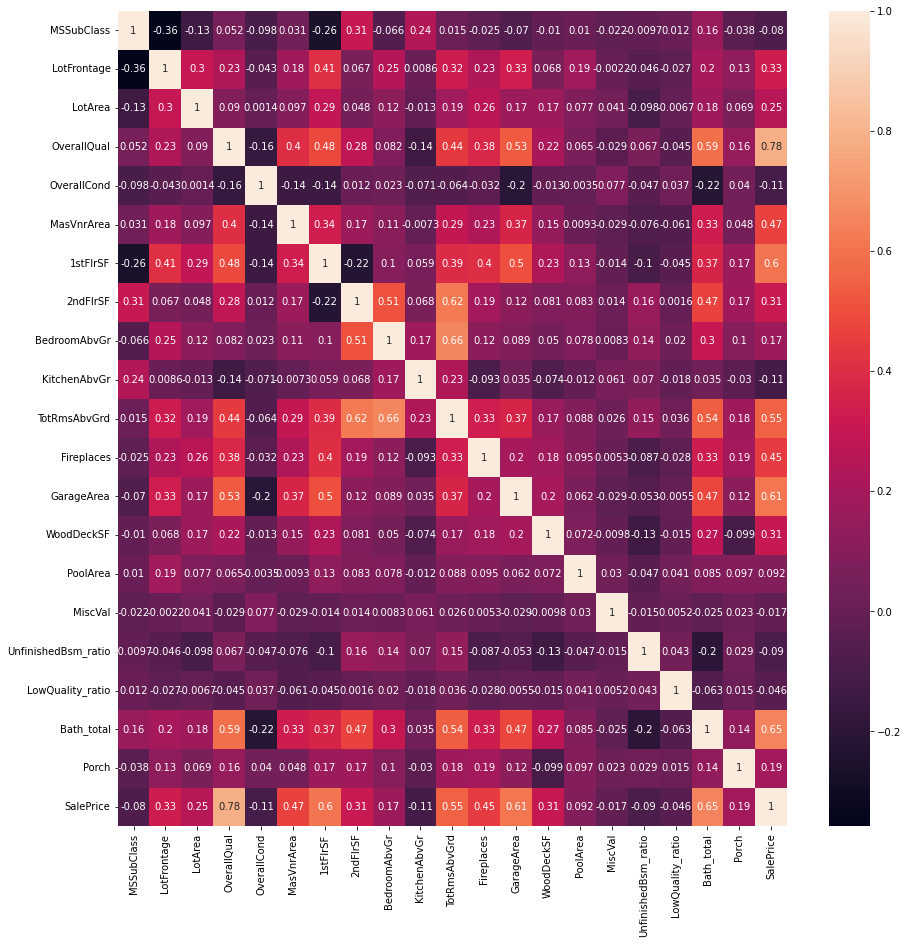

In [24]:
plt.figure(figsize = (15,15))
N = num.copy()
N.insert(len(N),'SalePrice')
sns.heatmap(train_data.loc[:, N].corr(),annot=True)

**QQ-Plot**

ln(Y)变量的正态性检验

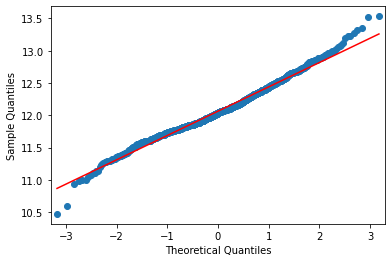

In [25]:
sm.qqplot(np.log(y_train), line = 's')
pylab.show()

In [26]:
# Standardize numerical features
stdSc = StandardScaler()
x_train.loc[:, num] = stdSc.fit_transform(x_train.loc[:, num])

离群值暂时没搞

**粗略回归**

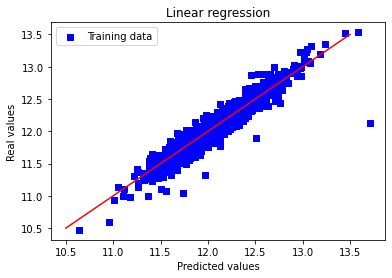

In [27]:
# Linear Regression
lr = LinearRegression()
lr.fit(x_train, np.log(y_train))

# Look at predictions on training and validation set
y_train_pred = lr.predict(x_train)

# Plot predictions
plt.scatter(y_train_pred, np.log(y_train), c = "blue", marker = "s", label = "Training data")
plt.title("Linear regression")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")
plt.show()

In [ ]:
model = sm.OLS(np.log(y_train),x_train)
results = model.fit()
print(results.summary())

In [ ]:
results.pvalues.index.values[results.pvalues.argmax()]

In [ ]:
import statsmodels.formula.api as smf
def forward_selected(data, response):
    """Linear model designed by forward selection.

    Parameters:
    -----------
    data : pandas DataFrame with all possible predictors and response

    response: string, name of response column in data

    Returns:
    --------
    model: an "optimal" fitted statsmodels linear model
           with an intercept
           selected by forward selection
           evaluated by AIC
    """
    remaining = set(data.columns)
    remaining.remove(response)
    selected = []
    current_score, best_new_score = 10000000, 10000000
    while remaining and current_score == best_new_score:
        scores_with_candidates = []
        for candidate in remaining:
            #formula = "{} ~ {} + 1".format(response,
            #                               ' + '.join(selected + [candidate]))
            score = sm.OLS(data[response], data[selected + [candidate]]).fit().aic
            scores_with_candidates.append((score, candidate))
        scores_with_candidates.sort(reverse = True)
        best_new_score, best_candidate = scores_with_candidates.pop()
        if current_score > best_new_score:
            remaining.remove(best_candidate)
            selected.append(best_candidate)
            current_score = best_new_score
        print(best_new_score)
        print(len(remaining))
    #formula = "{} ~ {} + 1".format(response,
     #                              ' + '.join(selected))
    model = sm.OLS(data[response], data[selected + [candidate]]).fit()
    return model

In [ ]:
try_data = pd.concat([x_train,y_train], axis = 1)
model_try = forward_selected(try_data, 'SalePrice')

In [30]:
def stepwise_selection(X, y, 
                       initial_list = [], 
                       threshold_in = 0.03, 
                       threshold_out = 0.05, 
                       verbose=True):
    """ Perform a forward-backward feature selection 
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features 
    Always set threshold_in < threshold_out to avoid infinite looping.
    See https://en.wikipedia.org/wiki/Stepwise_regression for the details
    """
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.index.values[new_pval.argmin()]
            included.append(best_feature)
            changed = True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.argmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included


In [31]:
a = stepwise_selection(x_train, y_train,initial_list=[])

Add  OverallQual                    with p-value 2.12471e-278
Add  1stFlrSF                       with p-value 2.06683e-57
Add  2ndFlrSF                       with p-value 1.97387e-52
Add  RoofMatl_ClyTile               with p-value 1.33199e-34
Add  KitchenQual_Ex                 with p-value 1.71237e-28
Add  UnfinishedBsm_ratio            with p-value 1.30718e-22
Add  YearBuilt_After1980            with p-value 7.87616e-22
Add  LotArea                        with p-value 4.68444e-15
Add  SaleType_New                   with p-value 6.07552e-13
Add  OverallCond                    with p-value 7.52945e-13
Add  BsmtExposure_Gd                with p-value 4.14197e-11
Add  MSSubClass                     with p-value 2.00642e-12
Add  MasVnrArea                     with p-value 3.19477e-10
Add  GarageArea                     with p-value 9.73707e-08
Add  KitchenAbvGr                   with p-value 5.58696e-07
Add  Functional_Typ                 with p-value 6.41509e-07
Add  RoofMatl_WdShngl  